In [10]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rdlib.rdlib41 as rd

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var


px,py =var('px:4'),var('py:4')
t = symbols('t')

from sympy import var

NSilF = './RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト


In [119]:
img = imgs[0]

conLeft,conRight = rd.getCntPairWithImg(img)

n_samples = 20
# 輪郭点を（チェインの並び順に）等間隔に n_samples 個サンプリングする。
cntL = (np.array(conLeft))[list(map(int,np.linspace(0, len(conLeft)-1,n_samples)))]
cntR = (np.array(conRight))[list(map(int,np.linspace(0, len(conRight)-1,n_samples)))]
    
res, cpx,cpy,LbezresX,LbezresY,Ltpara = fitBezierCurveN(cntL,precPara=0.01,N=6, debugmode=False)
res, cpx,cpy,RbezresX,RbezresY,Rtpara = fitBezierCurveN(cntR,precPara=0.01,N=6, debugmode=False)


.........o
....o

In [102]:

# 解なしの部分に np.inf が入っているのでその抜けを前後から補完推定してデータを埋める
def eraseinf(plist):
    while np.sum(plist) == np.inf: # 無限を含むなら除去を繰り返す
        for i in range(len(plist)):
            if np.sum(plist[i]) == np.inf :
                print("欠",end="")
                if (i !=0 and i !=len(plist)-1) and np.sum(plist[i-1]+plist[i+1]) != np.inf: # 当該は無限で、前後は無限ではない場合
                    plist = np.r_[plist[0:i],[(plist[i-1]+plist[i+1])/2],plist[i+1:]]
                elif len(plist[i:])>=3 and np.sum(plist[i+1]+plist[i+2]) != np.inf:
                    plist = np.r_[plist[0:i],[plist[i+2]-2*(plist[i+2]-plist[i+1])],plist[i+1:]]
                elif len(plist[0:i])>=2 and np.sum(plist[i-1]+plist[i-2]) != np.inf:
                    plist = np.r_[plist[0:i],[plist[i-2]-2*(plist[i-2]-plist[i-1])],plist[i+1:]]
    print("")
    return plist

RPARA=1.0
#  (13) N次ベジエフィッティング
def fitBezierCurveN(points,precPara=0.01,N=5,npoints=50,openmode=False,debugmode=False):
    # points フィッティング対象の点列（座標のリスト）
    # order 次数、openmode: 両端点フリー、Falseの時は両端点固定
 
    # ベジエ曲線を定義するのに使うシンボルの宣言
    P = [Symbol('P' + str(i)) for i in range(N+1)] # 制御点を表すシンボル（数値変数ではない）
    px = [var('px'+str(i)) for i in range(N+1)] # 制御点のx座標を表すシンボル
    py = [var('py'+str(i)) for i in range(N+1)] # 制御点のy座標を表すシンボル
    dx_ = [var('dx_'+str(i)) for i in range(N+1)] # 制御点におけるx微係数を表すシンボル
    dy_ = [var('dy_'+str(i)) for i in range(N+1)] # 制御点におけるy微係数を表すシンボル
 
    for i in range(N+1):
        P[i] = Matrix([px[i],py[i]]) 
   
    # いわゆる自乗誤差の一般式
    s,t= symbols('s,t')
    loss1 = (s - t)**2
    # 最小自乗法の目的関数の一般式
    def lossfunc(listA,listB):
        return sum([loss1.subs([(s,a),(t,b)]) for (a,b) in zip(listA,listB)])/2

    v = var('v')
    # N次のベジエ曲線の定義式制御点 P0~PN とパラメータ　　t　の関数として定義
    v = 1-t
    bezN = Matrix([0,0])
    for i in range(0,N+1):
        bezN = bezN + binomial(N,i)*v**(N-i)*t**i*P[i]

    # もし、inf データが含まれるならば、補完する
    points = eraseinf(points) # 無限大の値が含まれる場合、補間

    # 初期の推定パラメータの決定
    axlength = np.array(cv2.arcLength(points, False)) # 点列に沿って測った総経路長
    # 各サンプル点の始点からの経路長の全長に対する比を、各点のベジエパラメータの初期化とする
    tpara = [cv2.arcLength(points[:i+1],False)  for i in range(len(points))]/axlength 
    
    #  パラメトリック曲線　linefunc 上で各サンプル点に最寄りの点のパラメータを対応づける
    def refineTparaN(pl,linefunc,npoints=50):
        (funcX,funcY) = linefunc # funcX,funcY は t の関数
        # 各サンプル点に最も近い曲線上の点のパラメータ t を求める。
        delta = 1/(4*npoints)
        trange0 = np.arange(0,0.25,delta)       
        trange1 = np.arange(0.25,0.75,2*delta)
        trange2 = np.arange(0.75,1+delta,delta)
        trange = np.r_[trange0,trange1,trange2] # 最初の１/4 と最後の1/4 は近似精度が落ちるので２倍の点を用意する。
        onpoints = [[s,funcX.subs(t,s),funcY.subs(t,s)] for s in trange] # 曲線上にとった[パラメータ,サンプル点の座標]のリスト
        tpara = np.zeros(len(pl),np.float32) # 新しい 推定 t パラメータのリスト用の変数のアロケート
        refineTparaR(pl,tpara,0,len(pl),0,len(onpoints),onpoints) #  ０からなので、len(pl) 番はない　len(onpoints)番もない
        return tpara
       
    #  探索範囲内での対応づけ再帰関数        
    def refineTparaR(pl,tpara,stt,end,smin,smax,onpoints):
 
        # pl 点列、(stt,end) 推定しなくてならない点の番号の範囲, (smin,smax) パラメータ番号の探索範囲 
        # 範囲全体をサーチするのはかなり無駄なので、探索範囲をRARAで指定されている割合に絞る
        def srange(n,stt,end,smin,smax):
            # stt 番から end 番の点をパラメータ範囲 smin から smax でパラメータ割り当てをしている
            # ときに、ｎ番の点の最寄りの曲線上の点を探すときのパラメータの探索範囲を返す関数
            # n サーチ対象の点の番号、stt,end 
            if RPARA == 1 or end - stt < 3: # 無条件に全候補を対象とする
                return smin,smax
            else:
                prange = smax-smin # パラメータの探索幅
                orange = end-stt # 番号の幅
                lcand = smin + prange*(n-stt)//orange 
                left = int(lcand - prange*RPARA/2) if RPARA/2 < (n-ntt)/orange else smin
                left = smin+(n-stt)-1 if left < smin+(n-stt)-1 else left   # n番の左に未定がn-stt個あるので最低その分残してしておかないといけない
                right = int(lcand + prange*RPARA/2) if (end-n)/orange > RPARA/2 else smax
                right = smax-(end-n) if right > smax-(end-n) else right
                left = (int(left-0.5)   if int(left-0.5) > smin else smin) # 0.5 は　RPARAとは無関係なので注意
                right = (int(right+0.5) if int(right+0.5) < smax else smax)
                return left, right
                
        nmid = int((end+stt-1)/2) # 探索対象の中央のデータを抜き出す
        px,py = points[nmid] # 中央のデータの座標
        smin1, smax1 = srange(nmid,stt,end,smin,smax) # 初期サーチ範囲を決める
        if  smin1 == smax1 and stt == end:
            nearest_i = smin1 # = smax1
        else:
            while True:
                zahyo = (np.array(onpoints[smin1:smax1]).copy())[:,1:] # onpoints リストの座標部分のみ取り出し            
                differ = zahyo - np.array([px,py]) # 差分の配列
                distance = [x*x+y*y for x,y in differ] # 自乗誤差の配列
                nearest_i = smin1+np.argmin(distance) # 誤差最小のインデックス
                if (nearest_i > smin1 and nearest_i < smax1) or nearest_i == smin or nearest_i == smax:
                    if nearest_i - smin < nmid-stt: # 小さい側の残りリソースが不足
                        nearest_i = nearest_i+(nmid-stt)-(nearest_i-smin) 
                    elif smax-nearest_i < end-nmid: # 大きい側のリソースが不足
                        nearest_i = nearest_i-(end-nmid)+(smax-nearest_i)
                    break
                if smin1==smax1:
                    print("SAME")
                if nearest_i == smax1:
                    print(">",end=="")
                    (smin1,smax1) = (smax1-1, smax1 + 3) if smax1 + 3 < smax else (smax1-1,smax)
                elif nearest_i == smin1 :
                    print("<",end="")
                    (smin1,smax1) = (smin1 - 3, smin1+1) if smin1 - 3 > smin else (smin,smin1+1)
                 
        # nmid番のサンプル点に最も近い点のパラメータは、onpoints の nearest_i 番と確定
        tpara[nmid] = onpoints[nearest_i][0] # 中央点のパラメータが決定
        if nmid-stt >= 1 : # 左にまだ未処理の点があるなら処理する
            refineTparaR(pl,tpara, stt,nmid,smin,nearest_i,onpoints)
        if end-(nmid+1) >=1 : # 右にまだ未処理の点があるなら処理する
            refineTparaR(pl,tpara,nmid+1,end,nearest_i+1,smax,onpoints) 
                
    #ここまで確認

    trynum = 0
    while True:
        trynum += 1
        linepoints = [bezN.subs(t,t_) for t_ in tpara] # 曲線上の点列の式表現
        linepointsX = [x  for  [x,y] in linepoints] # X座標のリスト、式表現
        linepointsY = [y  for  [x,y] in linepoints] # Y座標のリスト、式表現
        EsumX = lossfunc(listA=points[:,0],listB=linepointsX) #  X方向のずれの評価値
        EsumY = lossfunc(listA=points[:,1],listB=linepointsY) #  Y 方向のずれの評価値
        # px0,px1, px2, px3, ... py1, py2,py3 ...で偏微分
        
        if  not openmode : # 両端点を固定
            EsumX = EsumX.subs(px[-1],points[-1][0])
            EsumY = EsumY.subs(py[-1],points[-1][1])
            EsumX = EsumX.subs(px[0],points[0][0])
            EsumY = EsumY.subs(py[0],points[0][1])
        for i in range(0,N+1):
            dx_[i] = diff(EsumX,px[i])
            dy_[i] = diff(EsumY,py[i])  
 
        # 連立させて解く
        if not openmode :
            resultX = solve([dx_[i] for i in range(1,N)],[px[i] for i in range(1,N)])
            resultY = solve([dy_[i] for i in range(1,N)],[py[i] for i in range(1,N)])
        else : 
            resultX = solve([dx_[i] for i in range(N+1)],[px[i] for i in range(N+1)])
            resultY = solve([dy_[i] for i in range(N+1)],[py[i] for i in range(N+1)])
        
        if len(resultX) == 0 or len(resultY) == 0: # 方程式が解けない　非常にまれなケース
            return False,np.array([]),np.array([]),None,None,None
        
        # 解をベジエの式に代入
        if not openmode:
            bezresX = bezN[0].subs([(px[0],points[0][0]),(px[-1],points[-1][0])])
            bezresY = bezN[1].subs([(py[0],points[0][1]),(py[-1],points[-1][1])])
            for i in range(1,N):
                bezresX = bezresX.subs(px[i],resultX[px[i]])
                bezresY = bezresY.subs(py[i],resultY[py[i]])
        else: 
            bezresX = bezN[0]
            bezresY = bezN[1]           
            for i in range(0,N+1):
                bezresX = bezresX.subs(px[i],resultX[px[i]])
                bezresY = bezresY.subs(py[i],resultY[py[i]])
            
        rx,ry = resultX,resultY
        if not openmode:
            cpx = [points[0][0]]+[rx[px[i]] for i in range(1,N)]+[points[-1][0]]
            cpy = [points[0][1]]+[ry[py[i]] for i in range(1,N)]+[points[-1][1]]    
        else: # openmode
            cpx = [rx[px[i]] for i in range(N+1)]
            cpy = [ry[py[i]] for i in range(N+1)]
        
        tpara0 = tpara.copy() # 元の t の推定値
        tpara = refineTparaN(points,(bezresX,bezresY),npoints=npoints) # 新たに推定値を求める
        diffpara = 0
        for i in range(len(tpara)) :
            diffpara += np.sqrt((tpara[i]-tpara0[i])**2) # 変化量の合計
        print(".",end='')
        diffpara = diffpara/len(tpara)
        if debugmode:
            print("TRY {0} diffpara {1:0.5f} : {2:0.5f}".format(trynum,diffpara*100,precPara*1.05**(0 if trynum <=5 else trynum-5)))
        if trynum <= 5:
            if diffpara < precPara/100:
                break
        else:
            if diffpara < precPara/100*1.05**(trynum-5): # 収束しない時のために、条件を徐々に緩めていく
                break
    print("o",end="")
        
    return True,np.array(cpx),np.array(cpy),bezresX,bezresY,tpara
    # cpx,cpy 制御点、bezresX,bezresY ベジエ曲線の定義式
    # tpara 制御点   
    

In [114]:
bezresX

144*t**3 + 50.6067239652818*t**2*(3 - 3*t) + 332.260247362459*t*(1 - t)**2 + 144*(1 - t)**3

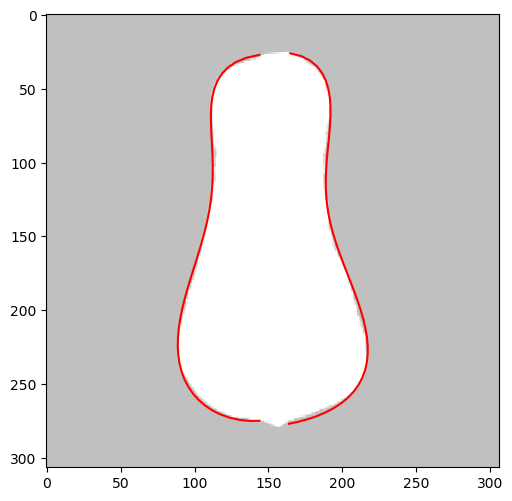

In [120]:
res,cpx,cpy,bezresX,bezresY,tpara
drawBez2("test",bezL=(LbezresX,LbezresY),bezR=(RbezresX,RbezresY))

In [115]:
rdimg = img
# 結果の描画
def drawBez2(savepath,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],PosC=[],n_samples=20,saveImage=False):
    
    # いわゆる自乗誤差の一般式
    s,t= symbols('s,t')
    
    bezXl,bezYl = bezL if bezL != None else ([],[])
    bezXr,bezYr = bezR if bezR != None else ([],[])
    bezXc,bezYc = bezC if bezC != None else ([],[])
    cpxl,cpyl = cpl if cpl != None else ([],[])
    cpxr,cpyr = cpr if cpr != None else ([],[])
    cpxc,cpyc = cpc if cpc != None else ([],[])
    tplins50 = np.linspace(0, 1, 50)
    tplinsSP = np.linspace(0, 1, n_samples)
    
    plt.figure(figsize=(6,6),dpi=100)
    plt.gca().invert_yaxis() 
    plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
    plt.imshow(192+(cv2.cvtColor(rdimg,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8))
    # 左輪郭の描画
    if bezL != None:
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
    if len(cntL) >0:
        plt.scatter(cntL[:,0],cntL[:,1],color ='blue',marker = '.') #  サンプル点
    if cpl != None:
        plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        for i in range(len(cpxl)) : plt.annotate(str(i),(cpxl[i],cpyl[i]))
    # 右輪郭の描画
    if bezR != None:
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
    if len(cntR)  > 0:
        plt.scatter(cntR[:,0],cntR[:,1],color ='blue',marker = '.') #  サンプル点
    if cpr != None:
        plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        for i in range(len(cpxr)):plt.annotate(str(i),(cpxr[i],cpyr[i]))
    # 中心軸の描画
    if bezC != None:
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        if cntC != None:
            plt.scatter(cntC[:,0],cntC[:,1],color ='blue',marker = '.') #  サンプル点
        if cpc != None:
            plt.scatter(cpxc,cpyc,color ='darkgreen',marker = '*') #  制御点の描画
            for i in range(len(cpxc)):plt.annotate(str(i),(cpxc[i],cpyc[i]))
                
        # ラダーの描画
        if  ladder== 'lr':  # 左右の同じパラメータ値の点を結ぶだけ
            plotSPlx = [bezXl.subs(t,tp) for tp in tplinsSP ]
            plotSPly = [bezYl.subs(t,tp) for tp in tplinsSP ]
            plotSPrx = [bezXr.subs(t,tp) for tp in tplinsSP ]
            plotSPry = [bezYr.subs(t,tp) for tp in tplinsSP ]       
            for x0,x1,y0,y1 in zip(plotSPlx,plotSPrx,plotSPly,plotSPry):
                plt.plot([x0,x1],[y0,y1],color = 'orange') 
                
        elif ladder == 'normal':
            # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
            plot20lx = [xl if xl !=np.inf else np.inf for [xl,yl] in PosL ]
            plot20ly = [yl if yl !=np.inf else np.inf for [xl,yl] in PosL]
            plot20cx = PosC[:,0]
            plot20cy = PosC[:,1]
            plot20rx = [xr if xr !=np.inf else np.inf for [xr,yr] in PosR ]
            plot20ry = [yr if yr !=np.inf else np.inf for [xr,yr] in PosR ]
            for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
                if x0 != np.inf and y0 !=np.inf:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
            for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
                if x0 != np.inf and y0 !=np.inf:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
            if saveImage:
                pltsaveimage(savepath,'RAD')
